In [1]:
from l3gs.data.utils.pyramid_embedding_dataloader2 import PyramidEmbeddingDataloader
from l3gs.data.utils.dino_dataloader2 import DinoDataloader
from l3gs.encoders.image_encoder import BaseImageEncoderConfig
from l3gs.encoders.openclip_encoder import OpenCLIPNetworkConfig
from datasets import load_dataset
from torch.utils import data
from typing import Dict, ForwardRef, Generic, List, Literal, Optional, Tuple, Type, Union, cast, get_args, get_origin
from torchvision import transforms
import matplotlib.pyplot as plt
from nerfstudio.utils.colormaps import apply_colormap
import torch

device = 'cuda:0'
"""The device to run on"""
patch_tile_size_range: Tuple[int, int] = (0.08, 0.5)
"""The range of tile sizes to sample from for patch-based training"""
patch_tile_size_res: int = 7
"""The number of tile sizes to sample from for patch-based training"""
patch_stride_scaler: float = 0.5
"""The stride scaler for patch-based training"""
network: BaseImageEncoderConfig = OpenCLIPNetworkConfig(device=device)
"""specifies the vision-language network config"""
clip_downscale_factor: int = 1
"""The downscale factor for the clip pyramid"""

dino_dataloader = DinoDataloader(
            # image_list=images,
            device=device,
            cfg={"image_shape": [480,640]},
            # cache_path=dino_cache_path,
        )
torch.cuda.empty_cache()

clip_interpolator = PyramidEmbeddingDataloader(
    device=device,
    cfg={
        "tile_size_range": list(patch_tile_size_range),
        "tile_size_res": patch_tile_size_res,
        "stride_scaler": patch_stride_scaler,
        "image_shape": [480,640],
    },
    model=network.setup()
)
image_encoder = clip_interpolator.model

transform = transforms.Compose([
    transforms.ToTensor()
])

2024-06-10 13:39:46.268216: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 13:39:46.292435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 13:39:46.292454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 13:39:46.293422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 13:39:46.298134: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import torchvision
import numpy as np
from matplotlib import pyplot as plt
def tt2clipinterp(tt_frame, clip_downscale_factor=1):
    to_pil = torchvision.transforms.ToPILImage()
    image = transform(to_pil(tt_frame.permute(2, 0, 1).to(torch.uint8)))
    clip_interpolator.generate_clip_interp(image)
    H, W = image.shape[1:]
    # scale = torch.tensor(0.1).to(device)
    scaled_height = H//clip_downscale_factor
    scaled_width = W//clip_downscale_factor

    x = torch.arange(0, scaled_width*clip_downscale_factor, clip_downscale_factor).view(1, scaled_width, 1).expand(scaled_height, scaled_width, 1).to(device)
    y = torch.arange(0, scaled_height*clip_downscale_factor, clip_downscale_factor).view(scaled_height, 1, 1).expand(scaled_height, scaled_width, 1).to(device)
    image_idx_tensor = torch.zeros(scaled_height, scaled_width, 1).to(device)
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    with torch.no_grad():
        # data["clip"], data["clip_scale"] = clip_interpolator(positions, scale)[0], clip_interpolator(positions, scale)[1]
        data = clip_interpolator(positions)[0].view(H, W, -1)
    return data

def tt2dino(tt_frame, clip_downscale_factor=1):
    im = tt_frame.permute(2, 0, 1).to(torch.float32)
    dino_dataloader.generate_dino_embed(im)
    H, W = im.shape[1:]
    # scale = torch.tensor(0.1).to(device)
    scaled_height = H//clip_downscale_factor
    scaled_width = W//clip_downscale_factor

    x = torch.arange(0, scaled_width*clip_downscale_factor, clip_downscale_factor).view(1, scaled_width, 1).expand(scaled_height, scaled_width, 1).to(device)
    y = torch.arange(0, scaled_height*clip_downscale_factor, clip_downscale_factor).view(scaled_height, 1, 1).expand(scaled_height, scaled_width, 1).to(device)
    image_idx_tensor = torch.zeros(scaled_height, scaled_width, 1).to(device)
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    # print(positions.device)
    with torch.no_grad():
        data = dino_dataloader(positions.cpu()).view(H, W, -1)
    return data


In [3]:
'''%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

depthimg1 = None
with open('/home/yujustin/HDD2/rs_diff_cap/cap1png/cap1_Depth_1717622487708.12353515625000.bin', 'rb') as f:
    depthimg1 = np.frombuffer(f.read(), dtype=np.float32).reshape(480, 848, 1)
with open('/home/yujustin/HDD2/rs_diff_cap/cap2png/_Depth_1717622591983.41064453125000.bin', 'rb') as f:
    depthimg2 = np.frombuffer(f.read(), dtype=np.float32).reshape(480, 848, 1)

f, axarr = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(15)
axarr[0].imshow(depthimg1[:,:,0])
axarr[1].imshow(depthimg2[:,:,0])
axarr[0].axis('off')
axarr[1].axis('off')
f.show()


# from IPython.display import Image
# Image(filename='/home/yujustin/HDD2/rs_diff_cap/cap1png/cap1png_Depth_1717622487708.12353515625000.png') 
'''

"%matplotlib inline\nimport numpy as np\nfrom matplotlib import pyplot as plt\n\ndepthimg1 = None\nwith open('/home/yujustin/HDD2/rs_diff_cap/cap1png/cap1_Depth_1717622487708.12353515625000.bin', 'rb') as f:\n    depthimg1 = np.frombuffer(f.read(), dtype=np.float32).reshape(480, 848, 1)\nwith open('/home/yujustin/HDD2/rs_diff_cap/cap2png/_Depth_1717622591983.41064453125000.bin', 'rb') as f:\n    depthimg2 = np.frombuffer(f.read(), dtype=np.float32).reshape(480, 848, 1)\n\nf, axarr = plt.subplots(1,2)\nf.set_figheight(15)\nf.set_figwidth(15)\naxarr[0].imshow(depthimg1[:,:,0])\naxarr[1].imshow(depthimg2[:,:,0])\naxarr[0].axis('off')\naxarr[1].axis('off')\nf.show()\n\n\n# from IPython.display import Image\n# Image(filename='/home/yujustin/HDD2/rs_diff_cap/cap1png/cap1png_Depth_1717622487708.12353515625000.png') \n"

In [4]:
'''depth_np_l2_dist = np.linalg.norm(depthimg1 - depthimg2, axis=2)
plt.imshow(depth_np_l2_dist)
plt.show()
import torch
depth_tt_frame1 = torch.from_numpy(depthimg1.astype(np.int8))
depth_tt_frame2 = torch.from_numpy(depthimg2.astype(np.int8))

l2_norm = torch.norm((depth_tt_frame1 - depth_tt_frame2).to(torch.float32), p=2, dim=2).mean()
print("L2-Norm: ", l2_norm.item())'''

'depth_np_l2_dist = np.linalg.norm(depthimg1 - depthimg2, axis=2)\nplt.imshow(depth_np_l2_dist)\nplt.show()\nimport torch\ndepth_tt_frame1 = torch.from_numpy(depthimg1.astype(np.int8))\ndepth_tt_frame2 = torch.from_numpy(depthimg2.astype(np.int8))\n\nl2_norm = torch.norm((depth_tt_frame1 - depth_tt_frame2).to(torch.float32), p=2, dim=2).mean()\nprint("L2-Norm: ", l2_norm.item())'

/tmp/ipykernel_76268/1628143692.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


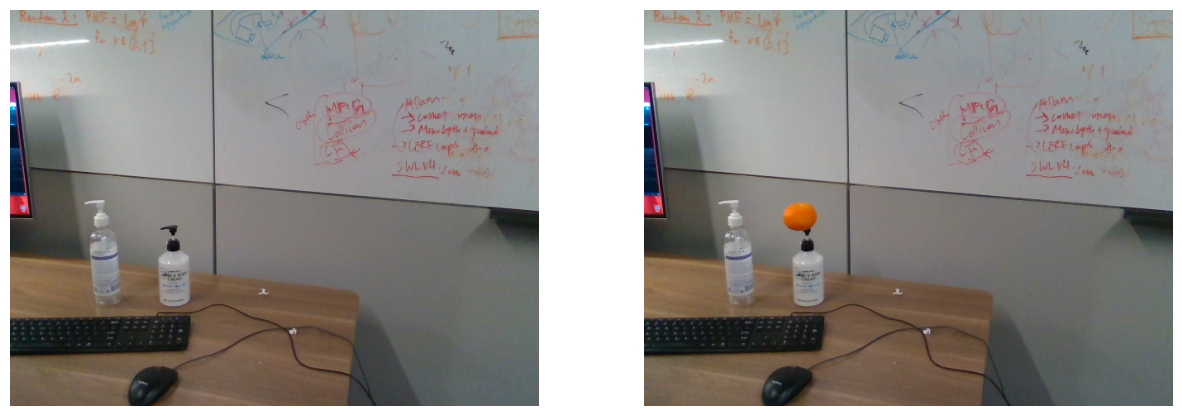

In [5]:
from PIL import Image
im_frame1 = Image.open('/home/yujustin/HDD2/rs_diff_cap/cap4png/_Color_1717622659099.65527343750000.png')
np_frame1 = np.array(im_frame1)
im_frame2 = Image.open('/home/yujustin/HDD2/rs_diff_cap/cap5png/_Color_1717622688820.22192382812500.png')
np_frame2 = np.array(im_frame2)

f, axarr = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(15)
axarr[0].imshow(np_frame1)
axarr[1].imshow(np_frame2)
axarr[0].axis('off')
axarr[1].axis('off')
f.show()

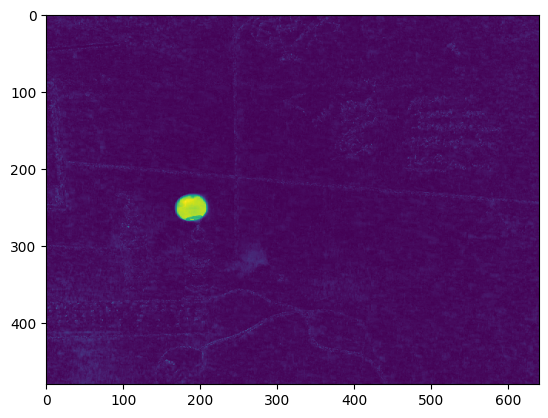

L2-Norm:  5.645310878753662


In [6]:
np_l2_dist = np.linalg.norm(np_frame1.astype(np.int8) - np_frame2.astype(np.int8), axis=2)
plt.imshow(np_l2_dist)
plt.show()
import torch
tt_frame1 = torch.from_numpy(np_frame1.astype(np.int8))
tt_frame2 = torch.from_numpy(np_frame2.astype(np.int8))

l2_norm = torch.norm((tt_frame1 - tt_frame2).to(torch.float32), p=2, dim=2).mean()
print("L2-Norm: ", l2_norm.item())

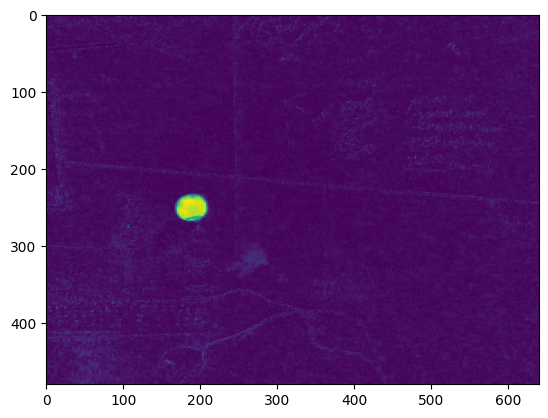

L1-Norm:  8.448551177978516


In [7]:
np_l1_dist = np.linalg.norm(np_frame1.astype(np.int8) - np_frame2.astype(np.int8), axis=2, ord=1)
plt.imshow(np_l1_dist)
plt.show()
import torch
tt_frame1 = torch.from_numpy(np_frame1.astype(np.int8))
tt_frame2 = torch.from_numpy(np_frame2.astype(np.int8))

l1_norm = torch.norm((tt_frame1 - tt_frame2).to(torch.float32), p=1, dim=2).mean()
print("L1-Norm: ", l1_norm.item())

Scales: 100%|██████████| 7/7 [00:00<00:00, 10822.02it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales:   0%|          | 0/7 [00:00<?, ?it/s]/home/yujustin/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Scales: 100%|██████████| 7/7 [00:00<00:00, 13.04it/s]


PyramidEmbeddingProcess took 0.5376033782958984 seconds


Scales: 100%|██████████| 7/7 [00:00<00:00, 10493.26it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales: 100%|██████████| 7/7 [00:00<00:00, 15.45it/s]


PyramidEmbeddingProcess took 0.4537382125854492 seconds
(480, 640)


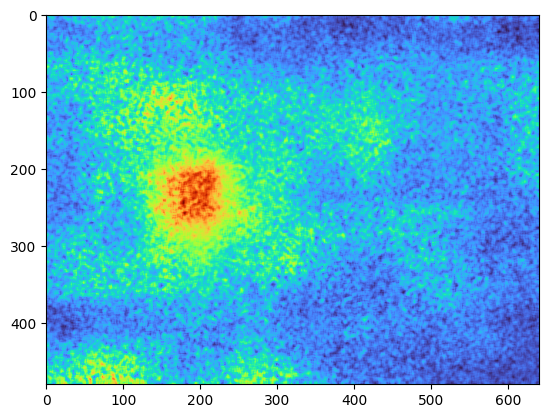

In [8]:
clip1 = tt2clipinterp(tt_frame1)
clip2 = tt2clipinterp(tt_frame2)
cos_sim = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
gaussian_blur = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(5.0))

np_cos_sim_clip = cos_sim(clip1, clip2).cpu().numpy()

np_cos_sim_clip = gaussian_blur(cos_sim(clip1, clip2).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).cpu().numpy()
print(np_cos_sim_clip.shape)

np_dist = (clip1.to(torch.float32) - clip2.to(torch.float32)).mean(dim=2).cpu().numpy()
#normalize to 0-1
np_dist = (np_dist - np_dist.min()) / (np_dist.max() - np_dist.min())

plt.imshow(np_cos_sim_clip, cmap='turbo_r')

# print((np_cos_sim == np_cos_sim.min()).nonzero())
# ch, cw = (np_cos_sim == np_cos_sim.min()).nonzero()
# circle1 = plt.Circle((cw, ch), 2, color='r')
# plt.gca().add_patch(circle1)
# plt.show()

Using cache found in /home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main
/home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


462
DinoEmbeddingProcess took 0.009708404541015625 seconds


Using cache found in /home/yujustin/.cache/torch/hub/facebookresearch_dinov2_main


462
DinoEmbeddingProcess took 0.0036263465881347656 seconds
torch.Size([480, 640, 384])
(480, 640)


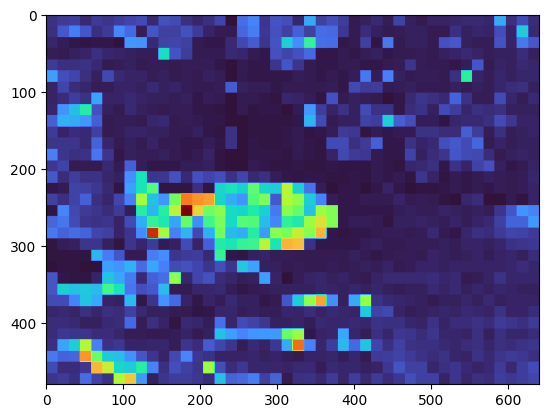

In [9]:
dino1 = tt2dino(tt_frame1)
dino2 = tt2dino(tt_frame2)
print(dino1.shape)

cos_sim = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
gaussian_blur = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(5.0))

np_cos_sim_dino = cos_sim(dino1, dino2).cpu().numpy()

# np_cos_sim = gaussian_blur(cos_sim(dino1, dino2).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).cpu().numpy()
print(np_cos_sim_dino.shape)

np_dist = (dino1.to(torch.float32) - dino2.to(torch.float32)).mean(dim=2).cpu().numpy()
#normalize to 0-1
np_dist = (np_dist - np_dist.min()) / (np_dist.max() - np_dist.min())

plt.imshow(np_cos_sim_dino, cmap='turbo_r')

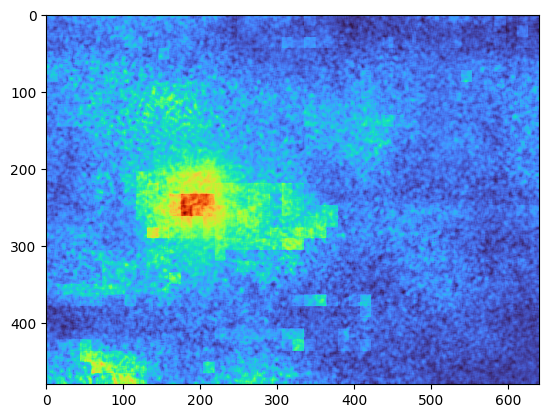

In [10]:
add = np_cos_sim_dino+np_cos_sim_clip
plt.imshow(add, cmap='turbo_r')

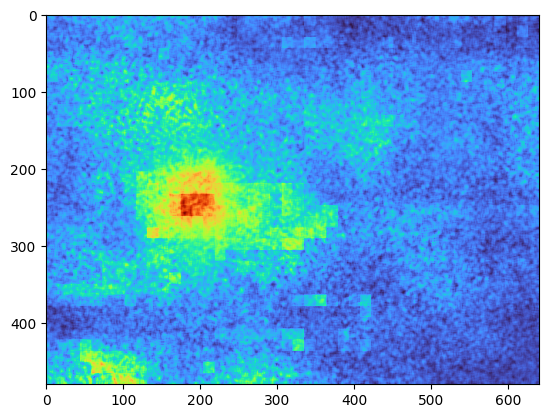

In [11]:
dot = np_cos_sim_dino*np_cos_sim_clip
plt.imshow(dot, cmap='turbo_r')

(array([257]), array([180]))


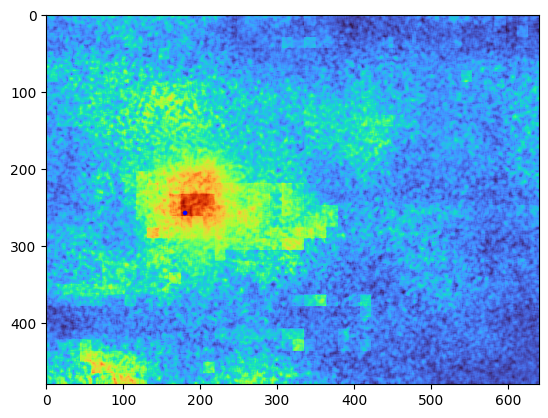

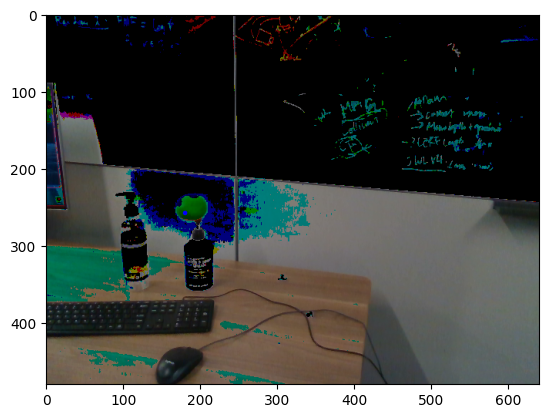

In [12]:
coss = -np.cos(np_cos_sim_dino*np_cos_sim_clip)
plt.imshow(coss, cmap='turbo_r')

print((coss == coss.min()).nonzero())
ch, cw = (coss == coss.min()).nonzero()
circle1 = plt.Circle((cw, ch), 2, color='b')
plt.gca().add_patch(circle1)
plt.show()

plt.cla()
plt.clf()

circle2 = plt.Circle((cw, ch), 2, color='b')
plt.imshow(tt_frame2)
plt.gca().add_patch(circle2)
plt.show()

-0.8543224
-0.5740789


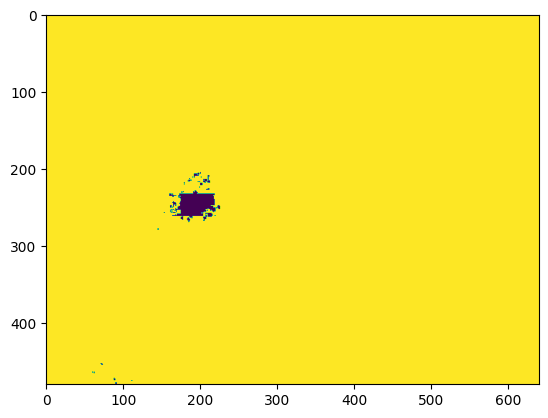

In [13]:
print(coss.min())
print(coss.max())

plt.imshow(coss >= -0.78)

In [14]:
'''
import scipy
from scipy import optimize
def gaussian(height, center_x, center_y, width_x, width_y, rotation):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)

    rotation = np.deg2rad(rotation)
    center_x = center_x * np.cos(rotation) - center_y * np.sin(rotation)
    center_y = center_x * np.sin(rotation) + center_y * np.cos(rotation)

    def rotgauss(x,y):
        xp = x * np.cos(rotation) - y * np.sin(rotation)
        yp = x * np.sin(rotation) + y * np.cos(rotation)
        g = height*np.exp(
            -(((center_x-xp)/width_x)**2+
                ((center_y-yp)/width_y)**2)/2.)
        return g
    return rotgauss

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y, 0.0


def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = scipy.optimize.leastsq(errorfunction, params)
    return p

sum_gauss = fitgaussian(coss)

print(sum_gauss)
plt.imshow()
'''

[ -0.57407892 239.43772384 315.39302492          nan          nan
   0.        ]


/tmp/ipykernel_76268/720760149.py:30: RuntimeWarning: invalid value encountered in sqrt
  width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
/tmp/ipykernel_76268/720760149.py:32: RuntimeWarning: invalid value encountered in sqrt
  width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())


TypeError: imshow() missing 1 required positional argument: 'X'

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# The two-dimensional domain of the fit.
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
noise_sigma = 0.1

# The function to be fit is Z.
Z = np.zeros(X.shape)
for p in gprms:
    Z += gaussian(X, Y, *p)
Z += noise_sigma * np.random.randn(*Z.shape)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
       arr += gaussian(x, y, *args[i*5:i*5+5])
    return arr

# Initial guesses to the fit parameters.
guess_prms = [(0, 0, 1, 1, 2),
              (-1.5, 5, 5, 1, 3),
              (-4, -1, 1.5, 1.5, 6),
              (4, 1, 1.5, 1.5, 6.5)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_gaussian, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)
for i in range(len(popt)//5):
    fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fit, cmap='plasma')
cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='plasma')
ax.set_zlim(-4,np.max(fit))
plt.show()

# Plot the test data as a 2D image and the fit as overlaid contours.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(Z, origin='bottom', cmap='plasma',
          extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(X, Y, fit, colors='w')
plt.show()

ImportError: cannot import name 'docstring' from 'matplotlib' (/home/yujustin/.local/lib/python3.10/site-packages/matplotlib/__init__.py)